# Imports

In [1]:
import math
from scipy.stats import norm
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec

# Black-Scholes Class

In [2]:
class BlackScholesModel:
    """
    Class to model options using the Black-Scholes model.
    """

    def __init__(
        self
    ) -> None:
        """
        Constructor
        """
    ############################
    # Pricing and implied vol
    ############################
    
    def d1_and_d2(
        self,  
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> tuple:
        """
        Function to calculate the tuple (d1, d2) in the Black-Scholes formula
        """
        # Calculate d1
        numerator_first = math.log(S / K)
        numerator_second = t * (r + (0.5 * (sigma ** 2)))
        denominator = sigma * math.sqrt(t)
        d1 = (numerator_first + numerator_second) / denominator

        # Calculate d2
        d2 = d1 - denominator

        return d1, d2
    
    def price(
        self,
        option_type,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the price of an option as in the Black-Scholes formula
        """
        # Calculate d1 and d2
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate price
        if option_type == 'Call':
            first_term = S * norm.cdf(d1)
            second_term = K * math.exp(-r * t) * norm.cdf(d2)
            value = first_term - second_term
        elif option_type == 'Put':
            first_term = K * math.exp(-r * t) * norm.cdf(-d2)
            second_term = S * norm.cdf(-d1)
            value = first_term - second_term
        else:
            raise ValueError("Invalid option_type. Must be 'Call' or 'Put'")

        return value

    def implied_vol(
        self,
        option_type: str,
        option_price: float,
        S: float,
        K: float,
        r: float,
        t: float
    ) -> float:
        """
        Function to numerically solve for the implied volatility of an option using its price.
        This is done by a minimization problem to minimize the difference between the price of 
        the option and the Black-Scholes price with implied vol as a variable.
        """
        # Cost function (least squares diff between option price and BS price)
        def cost_function(sigma):
            bs_price = self.price( 
                option_type=option_type,
                S=S,
                K=K,
                r=r,
                sigma=sigma,
                t=t
            )
            return (bs_price - option_price) ** 2

        # Solve for implied vol
        iv = minimize(
            fun=cost_function, 
            x0=0.2, 
            bounds=[(0.000001, 1000)], 
            method='L-BFGS-B', 
            tol=1e-6
        )
        
        return iv.x[0]
    
    ############################
    # Greeks
    ############################
    
    def delta(
        self,
        option_type: str,
        position: str,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the delta of an option derived from the Black-Scholes formula. 
        Delta measures the sensitivity of an option's price to a change in price of the underlying.
        """
        # Calculate d1 and d2 (only need d1)
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate delta
        if option_type == 'Call':
            value = norm.cdf(d1)
        elif option_type == 'Put':
            value = norm.cdf(d1) - 1
        else:
            raise ValueError("Invalid option_type. Must be 'Call' or 'Put'")

        # Negate if short
        if position == 'Long':
            return value
        elif position == 'Short':
            return - value
        else:
            raise ValueError("Position must be 'Long' or 'Short'")
    
    def gamma(
        self,
        position: str,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the gamma of an option derived from the Black-Scholes formula. 
        Gamma measures the sensitivity of an option's delta to a change in price of the underlying.
        """
        # Calculate d1 and d2 (only need d1)
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate gamma
        value = norm.pdf(d1) / (S * sigma * math.sqrt(t))

        # Negate if short
        if position == 'Long':
            return value
        elif position == 'Short':
            return - value
        else:
            raise ValueError("Position must be 'Long' or 'Short'")
        
    def vega(
        self,
        position: str,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the vega of an option derived from the Black-Scholes formula. 
        Vega measures the sensitivity of an option's price to a change in the volatility of the underlying.
        """
        # Calculate d1 and d2 (only need d1)
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate vega
        value = S * norm.pdf(d1) * math.sqrt(t)

        # Negate if short
        if position == 'Long':
            return value
        elif position == 'Short':
            return - value
        else:
            raise ValueError("Position must be 'Long' or 'Short'")

    def theta(
        self,
        option_type: str,
        position: str,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the theta of an option derived from the Black-Scholes formula. 
        Theta measures the sensitivity of an option's price to a change in the time to expiry.
        """
        # Calculate d1 and d2
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate terms needed for theta
        first_term = S * norm.pdf(d1) * sigma / (2 * math.sqrt(t))
        second_term_common_factor = r * K * math.exp(-r * t)
        
        # Calculate theta
        if option_type == 'Call':
            value = -first_term - (second_term_common_factor * norm.cdf(d2)) 
        elif option_type == 'Put':
            value = -first_term + (second_term_common_factor * norm.cdf(-d2)) 
        else:
            raise ValueError("Invalid option_type. Must be 'Call' or 'Put'")

        # Negate if short
        if position == 'Long':
            return value
        elif position == 'Short':
            return - value
        else:
            raise ValueError("Position must be 'Long' or 'Short'")

    def rho(
        self,
        option_type: str,
        position: str,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the rho of an option derived from the Black-Scholes formula. 
        Rho measures the sensitivity of an option's price to a change in the risk-free interest rate.
        """
        # Calculate d1 and d2
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate rho
        if option_type == 'Call':
            value = K * t * math.exp(-r * t) * norm.cdf(d2)
        elif option_type == 'Put':
            value = -K * t * math.exp(-r * t) * norm.cdf(-d2)
        else:
            raise ValueError("Invalid option_type. Must be 'Call' or 'Put'")

        # Negate if short
        if position == 'Long':
            return value
        elif position == 'Short':
            return - value
        else:
            raise ValueError("Position must be 'Long' or 'Short'")

    def vanna(
        self,
        position: str,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the vanna of an option derived from the Black-Scholes formula. 
        Vanna measures the sensitivity of an option's delta to a change in implied volatility. It equivalentally
        measures the sensititiby of an option's vega to a change in the underlying.
        """
        # Calculate d1 and d2 
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate vanna
        value = - math.sqrt(t) * norm.pdf(d1) * d2 / sigma

        # Negate if short
        if position == 'Long':
            return value
        elif position == 'Short':
            return -value
        else:
            raise ValueError("Position must be 'Long' or 'Short'")

    def charm(
        self,
        option_type: str,
        position: str,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the charm of an option derived from the Black-Scholes formula. 
        Charm measures the sensitivity of an option's delta to time passing.
        """
        # Calculate d1 and d2
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate charm
        bracket_first_term = r / (sigma * math.sqrt(t))
        bracket_second_term = d2 / (2 * t)
        value = - norm.pdf(d1) * (bracket_first_term - bracket_second_term)
            
        # Negate if short
        if position == 'Long':
            return value
        elif position == 'Short':
            return -value
        else:
            raise ValueError("Position must be 'Long' or 'Short'")

    ############################
    # Expiry Payoffs
    ############################

    def payoff(
        self,
        option_type: str,
        position: str,
        S: float,
        K: float,
    ) -> float:
        """
        Function to calculate the payoff at expiry for a single option position (long/short call or put)
        """
        # Check valid types and positions
        if (option_type not in ('Call', 'Put')) or (position not in ('Long', 'Short')):
            raise ValueError("'option_type' must be in ('Call', 'Put') and 'position' must be in ('Long', 'Short')")

        # Calculate payoff
        if option_type == 'Call':
            if position == 'Long':
                value = max(S - K, 0)
            else:
                value = -max(S - K, 0)
        else:
            if position == 'Long':
                value = max(K - S, 0)
            else:
                value = -max(K - S, 0)

        return value 

    def position_payoff(
        self,
        spots: np.ndarray,
        option_types: list,
        positions: list,
        strikes: np.ndarray,
    ) -> np.ndarray:
        """
        Given a multi-leg option position, calculate the payoff at expiry for the provided range of spot prices
        """
        # Calculate payoff at each spot price
        payoff_per_spot = [
            sum(
                [
                    self.payoff(
                        option_type=option_type,
                        position=position,
                        S=S,
                        K=K
                    )
                    for option_type, position, K in zip(option_types, positions, strikes)
                ]
            )
            for S in spots
        ]

        return np.array(payoff_per_spot)

    ############################
    # Simulations
    ############################

    def simulate_gbm(
        self, 
        n_steps: int,
        S_0: float,
        t: float,
        mu: float,
        sigma: float
    ) -> np.ndarray:
        """
        Function to simulate Geometric Brownian Motion of the underlying asset, returning the price path taken by the underlying asset as an array.
        """
        # Calculate time increment
        dt = t / n_steps
        
        # Initialise path array
        path = np.zeros(n_steps + 1)
        path[0] = S_0
        
        # Use discrete form of Geometric Brownian Motion SDE to generate the path
        for step in range(1, n_steps + 1):
            z = np.random.standard_normal()
            path[step] = path[step - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
        
        return path


# README
The aim of this notebook is to build a Black-Scholes class to explain theoretical questions I have about options. In particular, I want to especially explore how an option's P&L is affected by realised vs implied volatility. This paper by Paul Wilmott dives into the details: http://spekulant.com.pl/article/Delta%20Hedging/Which%20Free%20Lunch%20Would%20You%20Like%20TodaySir%20DeltaHedgingVolatility.pdf

This info can ultimately be used in a trading strategy on QuantConnect.

# Derivation of the Black-Scholes Equation

The Black-Scholes equation is a partial differential equation that describes the price of an option over time. It is derived using the following steps:

### Assumptions
1. The stock price follows a geometric Brownian motion with constant drift and volatility:
   $$
   dS_t = \mu S_t dt + \sigma S_t dW_t
   $$
   where $S_t$ is the stock price, $\mu$ is the drift rate, $\sigma$ is the volatility, and $W_t$ is a Wiener process.

2. There are no arbitrage opportunities.

3. Trading of the stock and the option is continuous.

4. There are no transaction costs or taxes.

5. The risk-free interest rate $r$ is constant.

### Portfolio Construction
Consider a portfolio $\Pi$ consisting of a long position in one option and a short position in $\Delta$ shares of the stock:
$$
\Pi = V - \Delta S
$$
where $V$ is the price of the option.

### Apply Itô's Lemma to the Option Price Differential
Using Itô's Lemma, the differential of the option price $V(S,t)$ is:
$$
dV = \frac{\partial V}{\partial t} dt + \frac{\partial V}{\partial S} dS + \frac{1}{2} \frac{\partial^2 V}{\partial S^2} (dS)^2
$$

Substituting $dS$ and $(dS)^2$:
$$
dS = \mu S dt + \sigma S dW
$$
$$
(dS)^2 = (\mu S dt + \sigma S dW)^2 = \mu^2 S^2 dt^2 + 2 \mu S \sigma S dt dW + \sigma^2 S^2 (dW)^2
$$

Since $dt^2$ and $dt dW$ are very small and can be ignored (formal proof needs measure theory), and $(dW)^2 = dt$, we get:
$$
(dS)^2 = \sigma^2 S^2 dt
$$

Thus,
$$
dV = \frac{\partial V}{\partial t} dt + \frac{\partial V}{\partial S} (\mu S dt + \sigma S dW) + \frac{1}{2} \frac{\partial^2 V}{\partial S^2} \sigma^2 S^2 dt
$$

Grouping terms, we get:
$$
dV = \left( \frac{\partial V}{\partial t} + \mu S \frac{\partial V}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} \right) dt + \sigma S \frac{\partial V}{\partial S} dW
$$

### Calculate Portfolio Differential
The differential of the portfolio $\Pi$ is:
$$
d\Pi = dV - \Delta dS
$$

Substituting $dV$ and $dS$:
$$
d\Pi = \left( \frac{\partial V}{\partial t} + \mu S \frac{\partial V}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} \right) dt + \sigma S \frac{\partial V}{\partial S} dW - \Delta (\mu S dt + \sigma S dW)
$$

Combining like terms:
$$
d\Pi = \left( \frac{\partial V}{\partial t} + \mu S \frac{\partial V}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} - \Delta \mu S \right) dt + \left( \sigma S \frac{\partial V}{\partial S} - \Delta \sigma S \right) dW
$$

### Eliminate Directional Risk with Delta

To eliminate risk, set $\Delta = \frac{\partial V}{\partial S}$ which simplifies things to:
$$
d\Pi = \left( \frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} \right) dt
$$
Notice this is deterministic (there is no $dW$ term).

### No-Arbitrage Condition
For no arbitrage, since the portfolio differential is deterministic, the portfolio must earn the risk-free rate:
$$
d\Pi = r \Pi dt
$$

Substituting our equation for $d\Pi$ and using $\Pi = V - \Delta S$ and $\Delta = \frac{\partial V}{\partial S}$, this becomes
$$
\left( \frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} \right) dt = r (V - S \frac{\partial V}{\partial S}) dt
$$

Rearranging terms we get the **Black-Scholes Equation**:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$


# Black-Scholes Formula

### Formula

The Black-Scholes formula is used to calculate the theoretical price of European call and put options. The formula is derived by solving the Black-Scholes equation.

The price of European call options ($C$) and European put options ($P$) is given by:
$$
C = S N(d_1) - K e^{-rT} N(d_2)
$$
and
$$
P = K e^{-rT} N(-d_2) - S N(-d_1)
$$
where:
$$
d_1 = \frac{\ln(S / K) + (r + \sigma^2 / 2) T}{\sigma \sqrt{T}}
$$
$$
d_2 = d_1 - \sigma \sqrt{T}
$$

where:

- $S$: Current stock price
- $K$: Strike price of the option
- $T$: Time to expiration (in years)
- $r$: Risk-free interest rate (annualized)
- $\sigma$: Volatility of the stock (annualized)
- $N(\cdot)$: Cumulative distribution function of the standard normal distribution

### Interpretation of the Formula, $d_1$ and $d_2$

Adapated from https://financetrainingcourse.com/education/2011/03/option-pricing-black-scholes-probabilities-explained-understanding-nd1-vs-nd2/
and Section 3 of https://financetrainingcourse.com/education/wp-content/uploads/2011/03/Understanding.pdf

Recall that the price of any financial instrument is just the present value of its expected future cashflows. We can interpret the Black-Scholes formula in exactly the same way!

If an option expires OTM or ATM, there are no future cashflows. However, if an option expires ITM, there are two future cashflows:
* Payment of the exercise price
* Receipt of the underlying

The two terms in the Black-Scholes formula simply give us the discounted expected value of each of these cashflows! In particular, the payment of the exercise price corresponds to the term containing $d_2$ and the receipt of the underlying corresponds to the term containing $d_1$.

Splitting up the option premium into these two terms allows us to give intuitive probability-based interpretations of $N(d_1)$ and $N(d_2)$. We give tge interpretations for calls but the logic for puts is identical.

#### Payment of the Exercise Price and $N(d_2)$

The exercise price payment is K. We first need to calculate its expected value. Since the payment only occurs if the option expires ITM, we have:
$$
E[K] = K P(S_T > K) + 0 P(S_T \leq K) = K P(S_T > K)
$$

Then we just need to discount this expected value to present value terms which gives

$$
K e^{-rT}P(S_T > K)
$$

Comparing this to the corresponding term in the Black-Scholes formula, we see that 
$$
N(d_2) = P(S_T > K)
$$

In other words: 
* For calls, **$N(d_2)$ is the probability that the option will expire ITM**.
* For puts, **$N(-d_2)$ is the probability that the option will expire ITM**.

#### Receipt of the Underlying and $N(d_1)$

The receipt of the underlying has value $S_T$. We first need to calculate its expected value. Since the receipt only occurs if the options expires ITM, we have:
$$
E[S_T] = E[S_T | S_T > K] P(S_T > K) + 0 P(S_T <= K) = E[S_T | S_T > K] P(S_T > K)
$$

Note the conditional expectation here. This is needed because in the event that the option expires ITM, to calculate the expected value of $S_T$, we should only consider scenarios where the option expires ITM otherwise we will underestimate the expected value. 

The proof is involved but it turns out that the above equation can be written as:
$$
E[S_T] = E[S_T | S_T > K] P(S_T > K) = e^{rT}SN(d_1)
$$
where $S$ is the current underlying price.

The present value of this expected value is then simply:
$$
SN(d_1)
$$

This tells us that $N(d_1)$ is the factor by which the present value of receipt of the underlying (conditional on the option expires ITM) exceeds the current stock price $S$ (and for calls it's $N(-d_1)$ )

# Greeks
The Greeks are measures of the sensitivity of an option's price to its underlying parameters. Here are the formulas which are derived by differentiating the Black-Scholes formula:

### Delta (Δ)
Delta measures the sensitivity of the option's price to changes in the price of the underlying asset. 
* For a call: $$ \Delta = \frac{\partial V}{\partial S} = N(d_1) $$
* For a put: $$ \Delta = \frac{\partial V}{\partial S} = N(d_1) - 1 = N(-d_1) $$

### Gamma (Γ)
Gamma measures the sensitivity of Delta to changes in the price of the underlying asset. 
$$ 
\Gamma = \frac{\partial^2 V}{\partial S^2} =  \frac{N'(d_1)}{S \sigma \sqrt{T}} 
$$ 

### Theta (Θ)
Theta measures the sensitivity of the option's price to the passage of time (time decay).
* For a call: $$ \Theta = \frac{\partial V}{\partial t} = -\frac{S N'(d_1) \sigma}{2 \sqrt{T}} - r K e^{-rT} N(d_2) $$
* For a put: $$ \Theta = \frac{\partial V}{\partial t} = -\frac{S N'(d_1) \sigma}{2 \sqrt{T}} + r K e^{-rT} N(-d_2) $$

### Vega (ν)
Vega measures the sensitivity of the option's price to changes in the volatility of the underlying asset. 

$$ \nu = \frac{\partial V}{\partial \sigma} = S \sqrt{T} N'(d_1) $$

### Vanna (ν)
Vega measures the sensitivity of the option's delta to changes in the volatility of the underlying asset. 

$$ vanna = \frac{\partial \Delta}{\partial \sigma} = T N'(d_1) (1 - d_1) $$

### Rho (ρ)
Rho measures the sensitivity of the option's price to changes in the risk-free interest rate. 
* For a call: $$ \rho = \frac{\partial V}{\partial r} = K T e^{-rT} N(d_2) $$
* For a put: $$ \rho = \frac{\partial V}{\partial r} = -K T e^{-rT} N(-d_2) $$

# Intuitive Explanation of Gamma

Gamma is one of the most important Greeks and yet slightly trickier to understand than some of the others. This section will give intuition behind gamma that I can use going forward. This reddit thread gives some good ideas https://www.reddit.com/r/options/comments/hb9tss/can_someone_explain_gamma_in_really_elementary/. 

### Gamma as an Acceleration

Firstly, let's look at a graph of an option's premium against the underlying spot price for a fixed point in time. In this case we look at a long call.

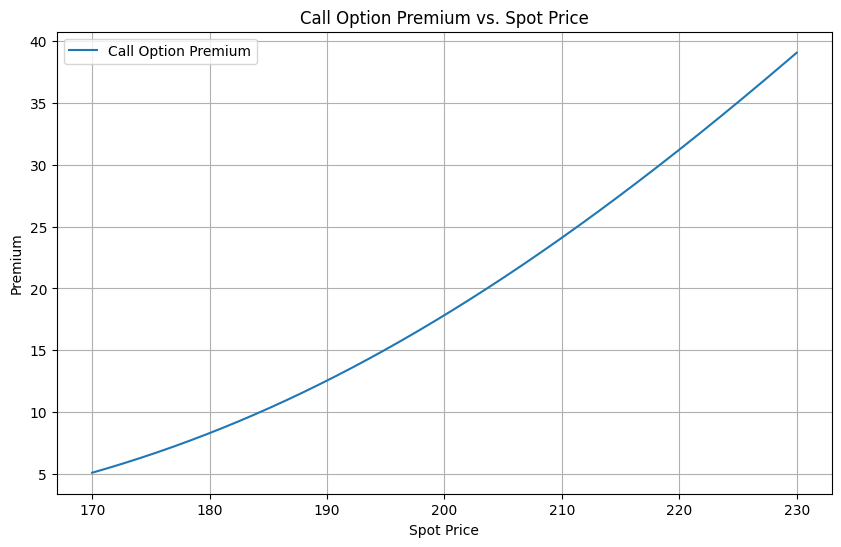

In [3]:
# Create Black-Scholes Model
bsm = BlackScholesModel()

# Calculate premium per spot
spots = np.linspace(170, 230, 1000)
premiums = [
    bsm.price(
        option_type='Call',
        S=S,
        K=200,
        r=0.02,
        sigma=0.2,
        t=1
    )
    for S in spots
]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(spots, premiums, label='Call Option Premium')
plt.title('Call Option Premium vs. Spot Price')
plt.xlabel('Spot Price')
plt.ylabel('Premium')
plt.legend()
plt.grid(True)
plt.show()


The most important things to take away from this graph are: 
1. Delta is the gradient (first derivative)
2. Gamma is the second derivative (how quickly the delta changes)
3. The option premium is a **convex** function of the spot price.

<div style="text-align: center; font-weight: bold; font-size: 1.2em; margin-top: 20px; margin-bottom: 20px;">
    The convexity of the premium against the spot price means that long options have positive gamma and short options have negative gamma. 
</div>

<div style="text-align: center; font-weight: bold; font-size: 1.2em; margin-top: 20px; margin-bottom: 20px; border: 2px solid white; padding: 10px;">
    Positive gamma leads to an acceleration of profits and a reduction of losses for buyers.
    Negative gamma leads to an acceleration of losses and a reduction of profits for sellers. 
</div>

There is a simple reason for this:
* If the underlying moves up some amount (in our favour for the long call), we profit and delta increases. Then if the underlying moves the same amount upwards again, we profit *even more* due to the new higher delta.
* If the underlying moves down by some amount (against us for the long call), we have a loss and delta decreases. Then if the underlying moves the same amount downwards again, we have a *smaller loss* due to the new smaller delta.

So being long gamma is desirable from a risk management perpsective.

### Gamma, Theta and Dynamic Delta Hedging

It may seem like we can use gamma to make a profit. For example, if we continuously delta hedge a long gamma position, we will be *selling* the underlying at higher prices and *buying* the underlying at lower prices, resulting in a net profit. e.g.

* Buy a call with a delta of 0.5 and gamma of 0.01.
* Delta hedge by shorting 50 shares of the underlying at \$100 each.
* Say the underlying increases to \$110 per share. Delta therefore increases by (gamma x change in price) = 0.01 x 10 = 0.1. So delta is now 0.6.
* To be delta neutral, we now need to be 60 shares short so we short another 10 shares at the new higher price of \$110 each.
* Now say the underlying decreases to \$90. Delta now decreases by (gamma x change in price) = 0.01 x -20  -0.2. So delta is now 0.4.
* To be delta neutral, we now need to be 40 shares short so we buy back 20 shares at the new lower price of \$90 each.
* Finally, underlying returns to $100 and we close the position by selling the call and buying back the 40 shares we are short.

The cashflows from delta hedging are:
* +50 x 100 = \$5000
* +10 x 110 = \$1100
* -20 * 90 = \$1800
* -40 * 100 = \$4000

which results in a total profit of \$300 just from hedging activity.

However, this profit can't be free. So what's the catch? That's where theta comes in. Theta will act to decay the value of the long gamma position. More specifically for long gamma positions:

<div style="text-align: center; font-weight: bold; font-size: 1.2em; margin-top: 20px; margin-bottom: 20px; border: 2px solid white; padding: 10px;">
    
If subseqeuent realised volatility is exactly equal to the implied volatility at the time of entry, the profits from dynamically delta hedging will be perfectly cancelled out by theta decay.

If subseqeuent realised volatility is greater than the implied volatility at the time of entry, the profits from dynamically delta hedging will outweigh theta decay.

If subseqeuent realised volatility is less than the implied volatility at the time of entry, the profits from dynamically delta hedging will be outweighed by theta decay.

</div>

So being long gamma can be thought of as being long realised vol (vs implied) and being short gamma can be thought of being short realised vol (vs implied).
# TODO: This isn't quite right as it's day to day differences and path dependent. Talk about it in more detail.


# Exploring Greeks

## Delta
* Delta measures the sensitivity of the option price to changes in the price of the underlying.
* Delta takes values between 0 and 1 for bullish positions (long calls, short puts) or between 0 and -1 for bearish positions (long puts, short calls).
* ITM options have deltas close to 1 (or -1). OTM options have deltas close to 0. ATM options have deltas close to 0.5.
* Delta is an ESTIMATE of the probability that an option will expire ITM.
* Delta is affected by 3 factors which correspond to other Greeks:
    * The underlying price S (gamma)
    * Volatility $\sigma$ (vanna)
    * Time to expiry $t$ (charm)

<ipython-input-4-6d8e310efe3f>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


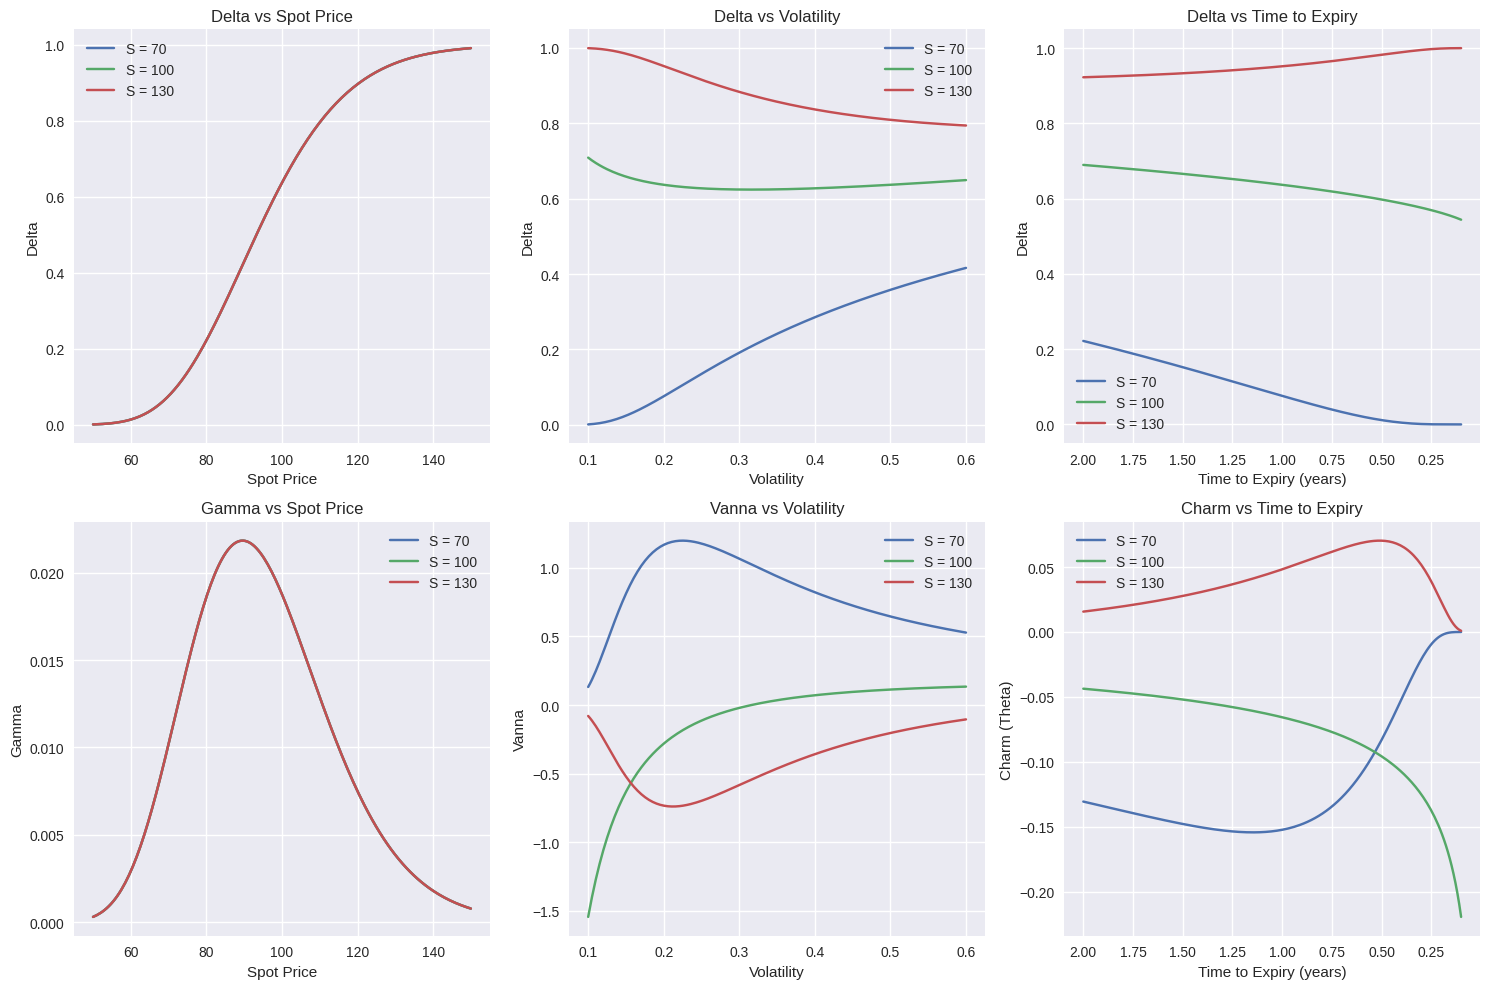

In [4]:
# Set up the figure
plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig)

# Fixed parameters
K = 100 
r = 0.05
option_type = 'Call'
position = 'Long'

# Generate data ranges
spot_range = np.linspace(50, 150, 200)
vol_range = np.linspace(0.1, 0.6, 200)
time_range = np.linspace(0.1, 2, 200)

# Default values when varying other parameters
default_sigma = 0.2
default_t = 1

# First row - Delta plots
# Delta vs Spot
ax1 = fig.add_subplot(gs[0, 0])
for S in [70, 100, 130]:
    delta_spot = [bsm.delta(option_type, position, S, K, r, default_sigma, default_t) 
                 for S in spot_range]
    ax1.plot(spot_range, delta_spot, label=f'S = {S}')
ax1.set_title('Delta vs Spot Price')
ax1.set_xlabel('Spot Price')
ax1.set_ylabel('Delta')
ax1.grid(True)
ax1.legend()

# Delta vs Volatility
ax2 = fig.add_subplot(gs[0, 1])
for S in [70, 100, 130]:
    delta_vol = [bsm.delta(option_type, position, S, K, r, sigma, default_t) 
                for sigma in vol_range]
    ax2.plot(vol_range, delta_vol, label=f'S = {S}')
ax2.set_title('Delta vs Volatility')
ax2.set_xlabel('Volatility')
ax2.set_ylabel('Delta')
ax2.grid(True)
ax2.legend()

# Delta vs Time
ax3 = fig.add_subplot(gs[0, 2])
for S in [70, 100, 130]:
    delta_time = [bsm.delta(option_type, position, S, K, r, default_sigma, t) 
                 for t in time_range]
    ax3.plot(time_range, delta_time, label=f'S = {S}')
ax3.invert_xaxis()
ax3.set_title('Delta vs Time to Expiry')
ax3.set_xlabel('Time to Expiry (years)')
ax3.set_ylabel('Delta')
ax3.grid(True)
ax3.legend()

# Gamma vs Spot
ax4 = fig.add_subplot(gs[1, 0])
for S in [70, 100, 130]:
    gamma_spot = [bsm.gamma(position, S, K, r, default_sigma, default_t) 
                 for S in spot_range]
    ax4.plot(spot_range, gamma_spot, label=f'S = {S}')
ax4.set_title('Gamma vs Spot Price')
ax4.set_xlabel('Spot Price')
ax4.set_ylabel('Gamma')
ax4.grid(True)
ax4.legend()

# Vanna vs Volatility
ax5 = fig.add_subplot(gs[1, 1])
for S in [70, 100, 130]:
    vanna_vol = [bsm.vanna(position, S, K, r, sigma, default_t) 
                for sigma in vol_range]
    ax5.plot(vol_range, vanna_vol, label=f'S = {S}')
ax5.set_title('Vanna vs Volatility')
ax5.set_xlabel('Volatility')
ax5.set_ylabel('Vanna')
ax5.grid(True)
ax5.legend()

# Charm vs Time
ax6 = fig.add_subplot(gs[1, 2])
for S in [70, 100, 130]:
    charm_time = [bsm.charm(option_type, position, S, K, r, default_sigma, t) 
                 for t in time_range]
    ax6.plot(time_range, charm_time, label=f'S = {S}')
ax6.invert_xaxis()
ax6.set_title('Charm vs Time to Expiry')
ax6.set_xlabel('Time to Expiry (years)')
ax6.set_ylabel('Charm (Theta)')
ax6.grid(True)
ax6.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


## How do Greeks change as you move towards expiry? How is this vary by moneyness?

In [5]:
# Fixed properties of each option
K = 200
r = 0.05
sigma = 0.1

# Data across all plots
expiries = np.linspace(0.001, 3, 1000)
spots = [K-30, K, K+30]
option_types = ['Call', 'Put']
positions = ['Long', 'Short']

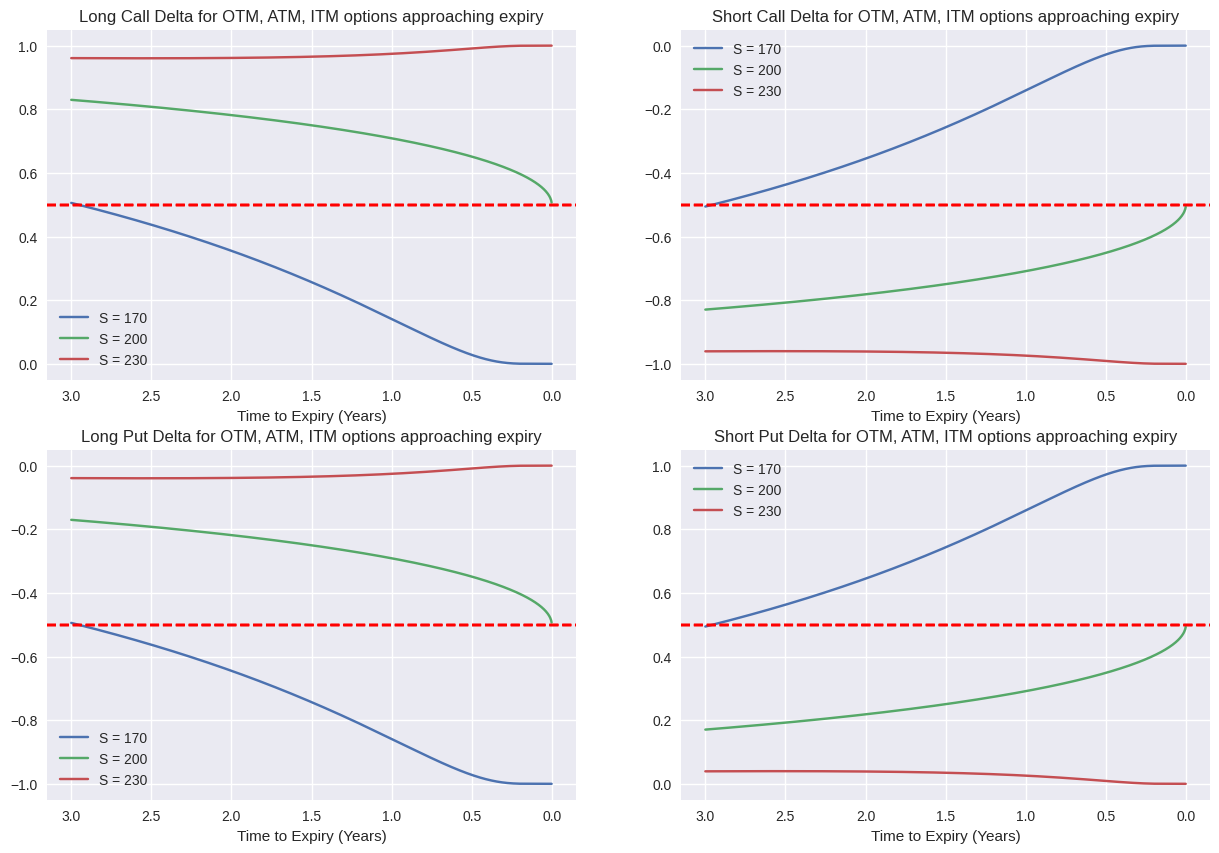

In [6]:
###############################
# Delta
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate delta across expiries for each spot price    
        deltas_per_spot = [
            [
                bsm.delta(
                    option_type=option_type,
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=sigma,
                    t=exp
                ) 
                for exp in expiries
            ]
            for spot in spots
        ]

        # Plot graph
        for deltas, spot in zip(deltas_per_spot, spots):
            ax[i, j].plot(expiries, deltas, label=f"S = {spot}")
            if (option_type == 'Call' and position == 'Long') or (option_type == 'Put' and position == 'Short'):
                ax[i, j].axhline(y=0.5, linestyle='--', color='r')
            else:
                ax[i, j].axhline(y=-0.5, linestyle='--', color='r')
            ax[i, j].invert_xaxis()
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Delta for OTM, ATM, ITM options approaching expiry")
            ax[i, j].set_xlabel('Time to Expiry (Years)')

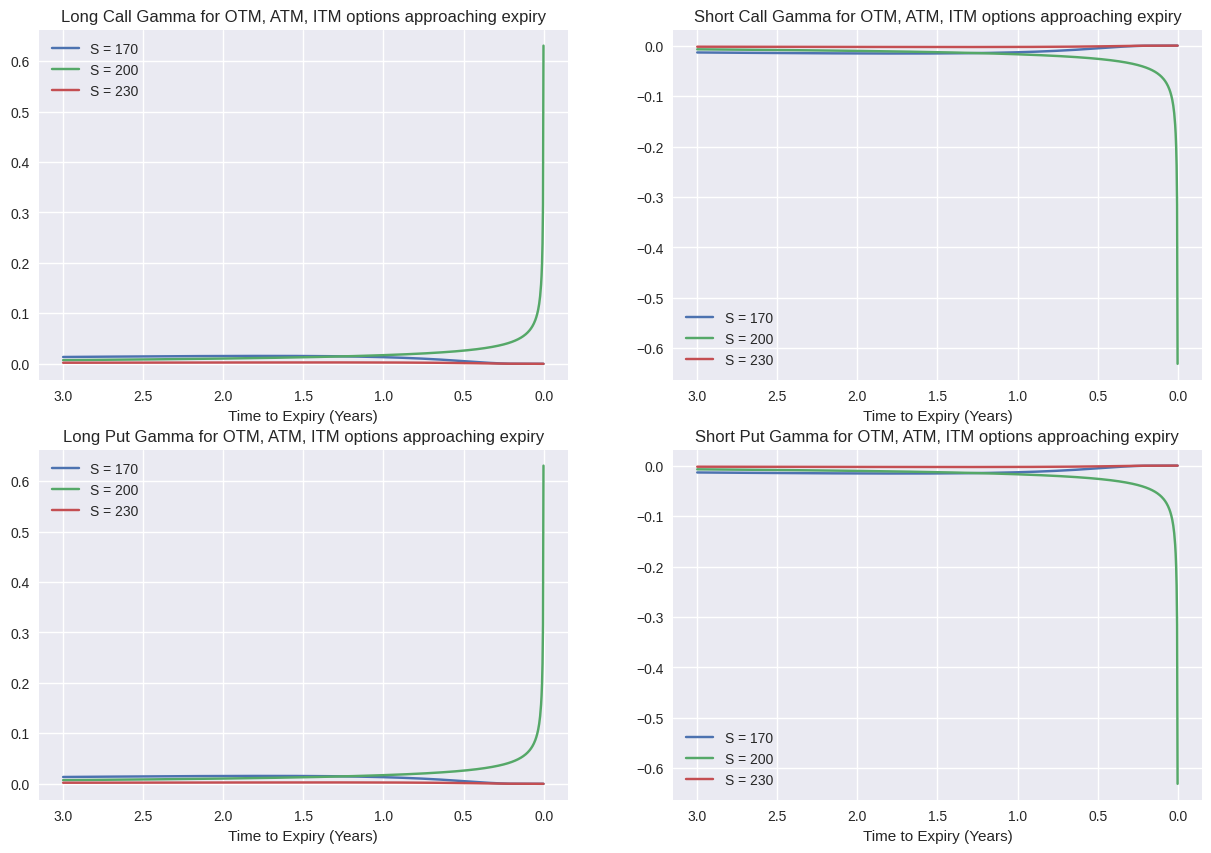

In [7]:
###############################
# Gamma
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate gamma across expiries for each spot price    
        gammas_per_spot = [
            [
                bsm.gamma(
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=sigma,
                    t=exp
                ) 
                for exp in expiries
            ]
            for spot in spots
        ]

        # Plot graph
        for gammas, spot in zip(gammas_per_spot, spots):
            ax[i, j].plot(expiries, gammas, label=f"S = {spot}")
            ax[i, j].invert_xaxis()
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Gamma for OTM, ATM, ITM options approaching expiry")
            ax[i, j].set_xlabel('Time to Expiry (Years)')

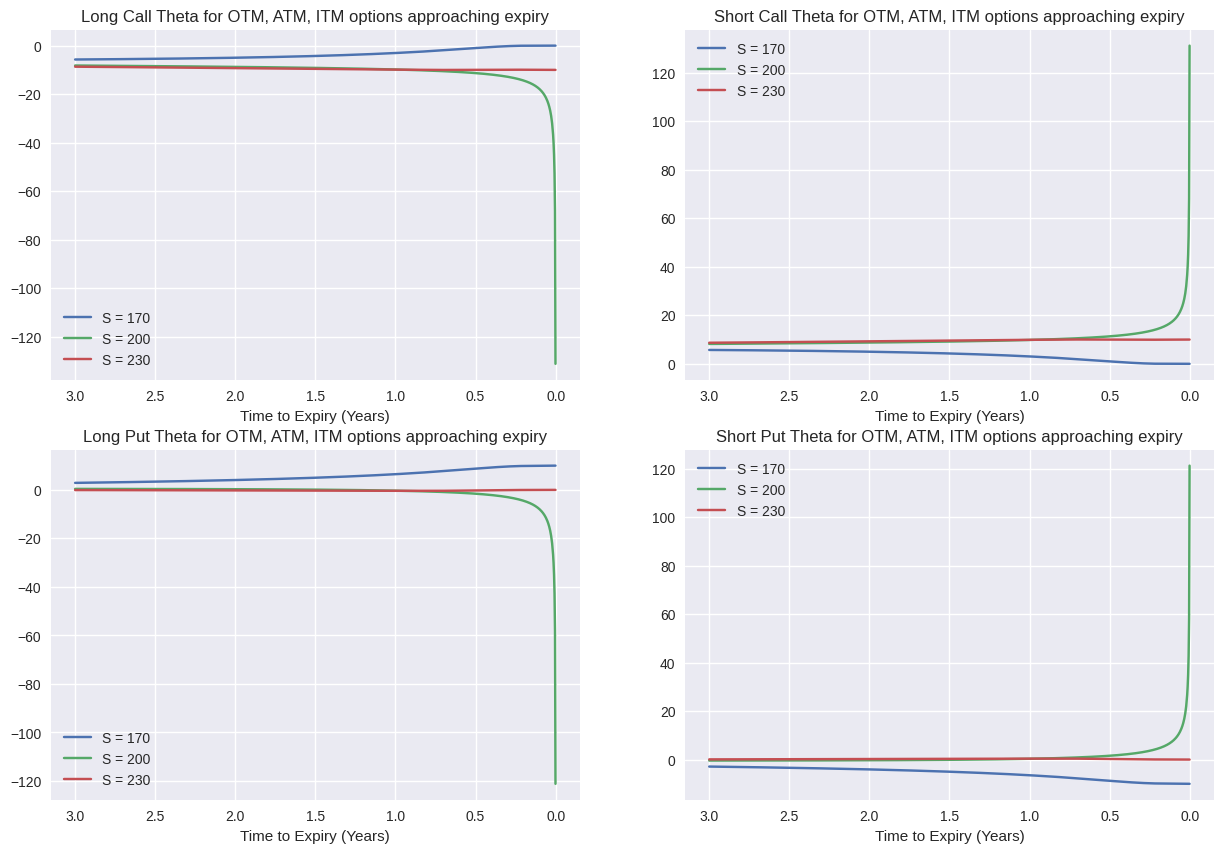

In [8]:
###############################
# Theta
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate theta across expiries for each spot price    
        thetas_per_spot = [
            [
                bsm.theta(
                    option_type=option_type,
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=sigma,
                    t=exp
                ) 
                for exp in expiries
            ]
            for spot in spots
        ]

        # Plot graph
        for thetas, spot in zip(thetas_per_spot, spots):
            ax[i, j].plot(expiries, thetas, label=f"S = {spot}")
            ax[i, j].invert_xaxis()
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Theta for OTM, ATM, ITM options approaching expiry")
            ax[i, j].set_xlabel('Time to Expiry (Years)')

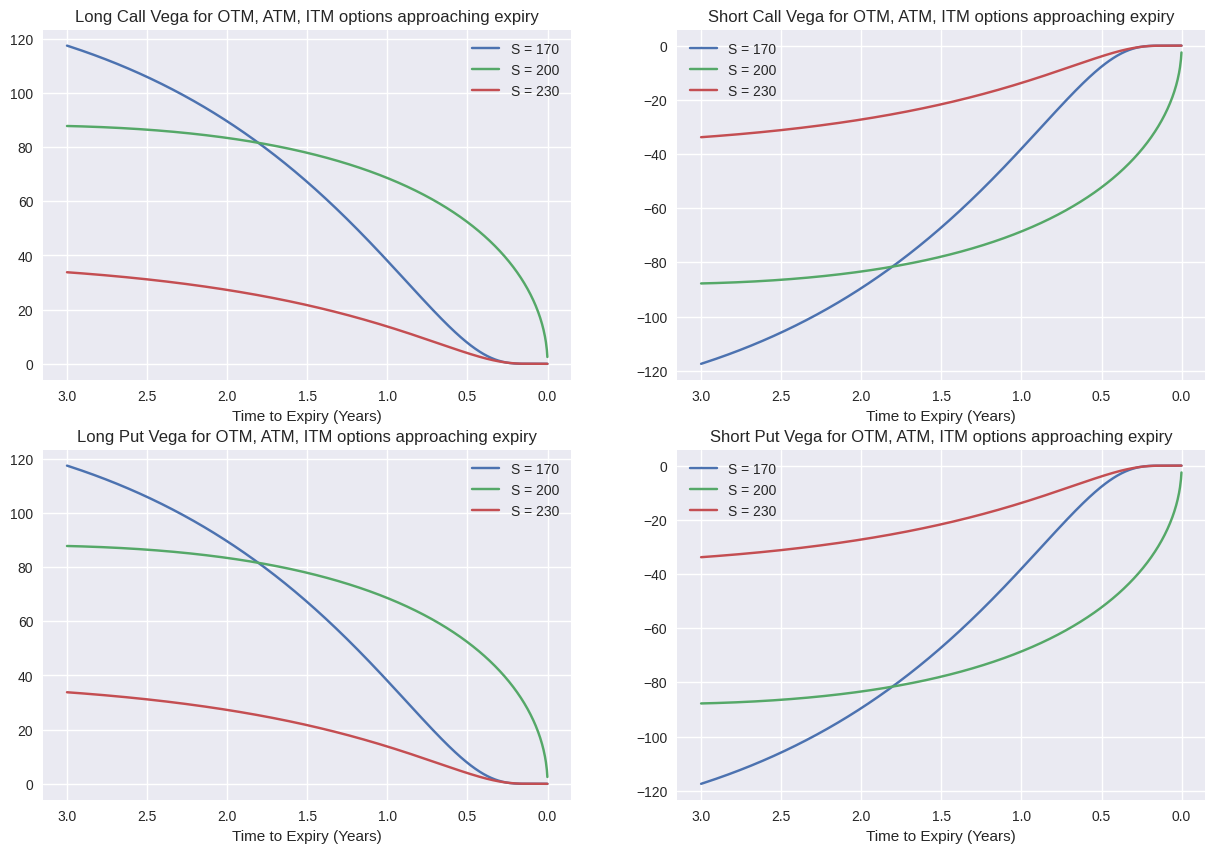

In [9]:
###############################
# Vega
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate vega across expiries for each spot price    
        vegas_per_spot = [
            [
                bsm.vega(
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=sigma,
                    t=exp
                ) 
                for exp in expiries
            ]
            for spot in spots
        ]

        # Plot graph
        for vegas, spot in zip(vegas_per_spot, spots):
            ax[i, j].plot(expiries, vegas, label=f"S = {spot}")
            ax[i, j].invert_xaxis()
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Vega for OTM, ATM, ITM options approaching expiry")
            ax[i, j].set_xlabel('Time to Expiry (Years)')

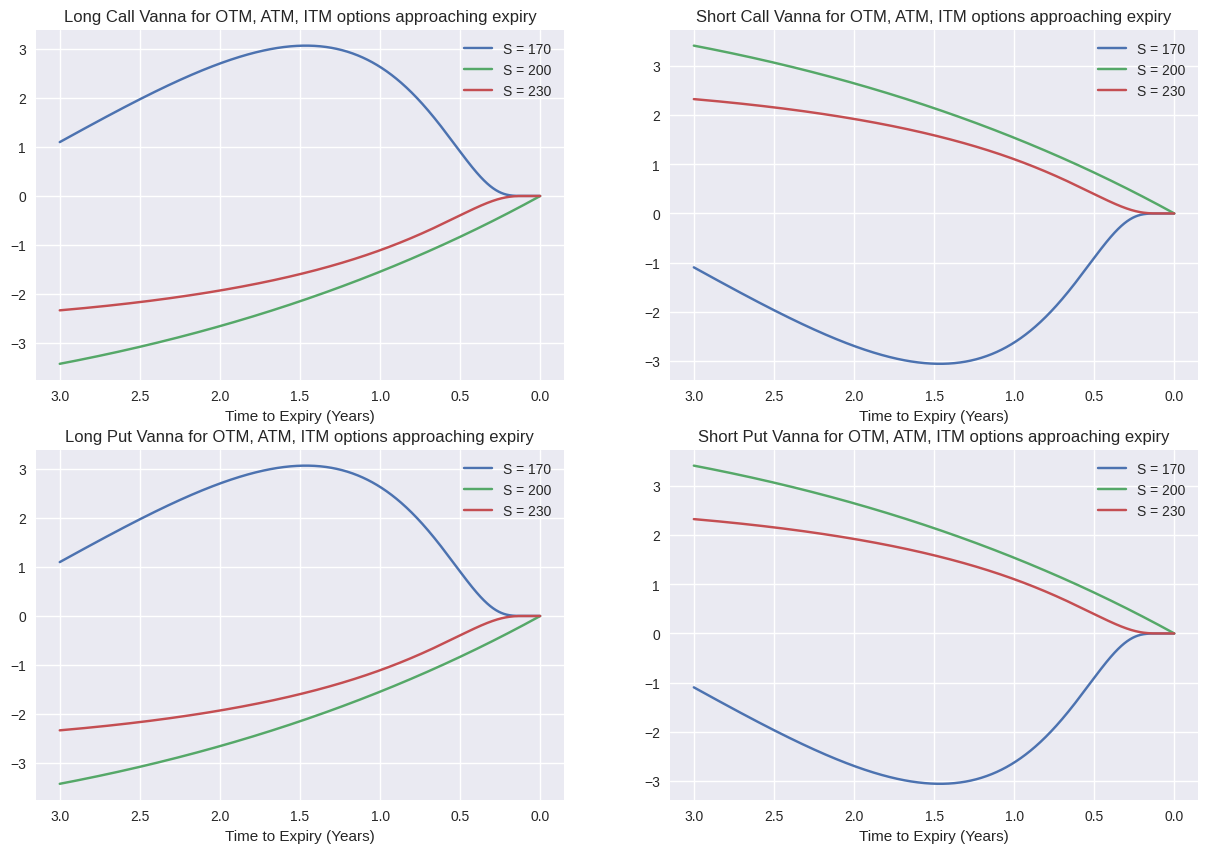

In [10]:
###############################
# Vanna
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate vanna across expiries for each spot price    
        vannas_per_spot = [
            [
                bsm.vanna(
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=sigma,
                    t=exp
                ) 
                for exp in expiries
            ]
            for spot in spots
        ]

        # Plot graph
        for vannas, spot in zip(vannas_per_spot, spots):
            ax[i, j].plot(expiries, vannas, label=f"S = {spot}")
            ax[i, j].invert_xaxis()
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Vanna for OTM, ATM, ITM options approaching expiry")
            ax[i, j].set_xlabel('Time to Expiry (Years)')

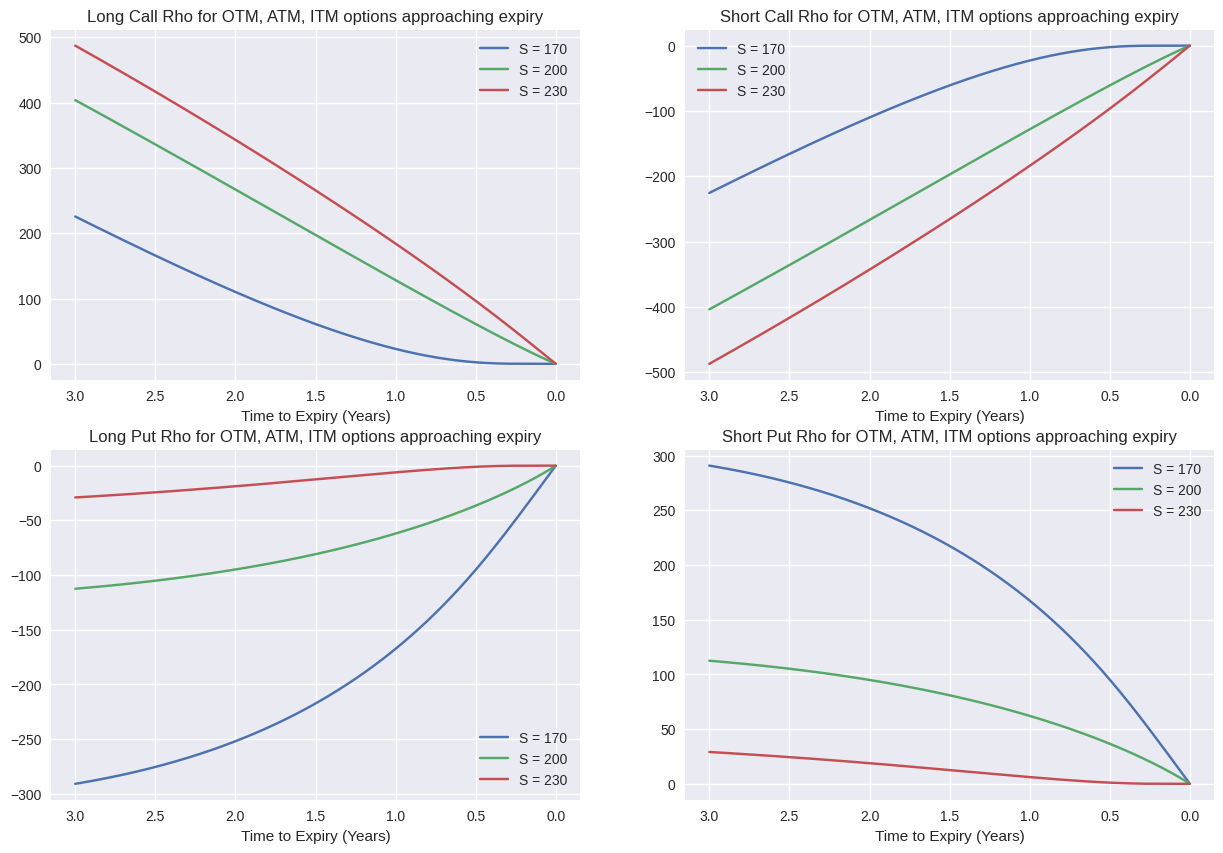

In [11]:
###############################
# Rho
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate rho across expiries for each spot price    
        rhos_per_spot = [
            [
                bsm.rho(
                    option_type=option_type,
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=sigma,
                    t=exp
                ) 
                for exp in expiries
            ]
            for spot in spots
        ]

        # Plot graph
        for rhos, spot in zip(rhos_per_spot, spots):
            ax[i, j].plot(expiries, rhos, label=f"S = {spot}")
            ax[i, j].invert_xaxis()
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Rho for OTM, ATM, ITM options approaching expiry")
            ax[i, j].set_xlabel('Time to Expiry (Years)')

## How do Greeks change by moneyness? How does this vary by IV?

In [12]:
# Fixed properties of each option
K = 200
r = 0.05
t = 0.5

# Data across all plots
spots = np.linspace(K-50, K+50, 1000)
ivs = [0.1, 0.15, 0.2, 0.25, 0.3]
option_types = ['Call', 'Put']
positions = ['Long', 'Short']

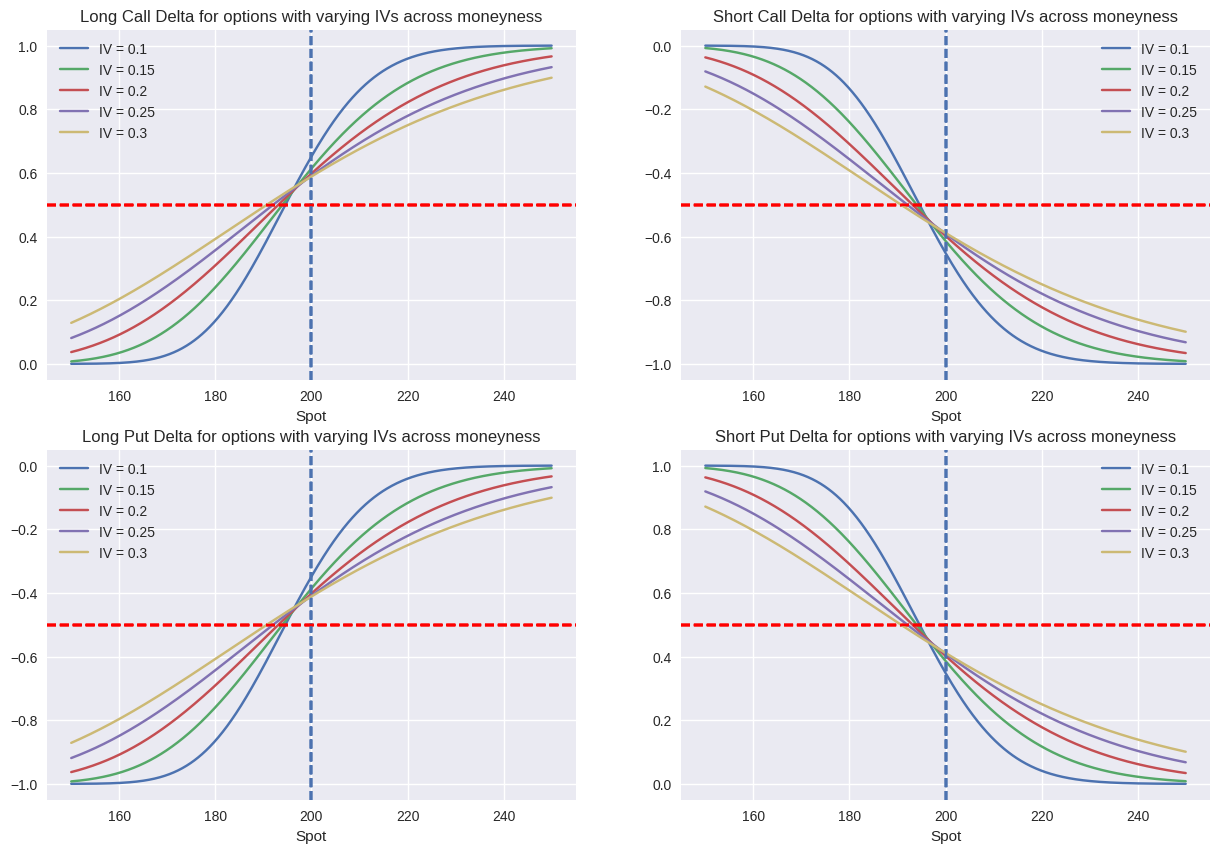

In [13]:
###############################
# Delta
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate delta across spots for each IV    
        deltas_per_iv = [
            [
                bsm.delta(
                    option_type=option_type,
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=iv,
                    t=t
                ) 
                for spot in spots
            ]
            for iv in ivs
        ]

        # Plot graph
        for deltas, iv in zip(deltas_per_iv, ivs):
            ax[i, j].plot(spots, deltas, label=f"IV = {iv}")
            ax[i, j].axvline(x=K, linestyle='--')
            if (option_type == 'Call' and position == 'Long') or (option_type == 'Put' and position == 'Short'):
                ax[i, j].axhline(y=0.5, linestyle='--', color='r')
            else:
                ax[i, j].axhline(y=-0.5, linestyle='--', color='r')
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Delta for options with varying IVs across moneyness")
            ax[i, j].set_xlabel('Spot')

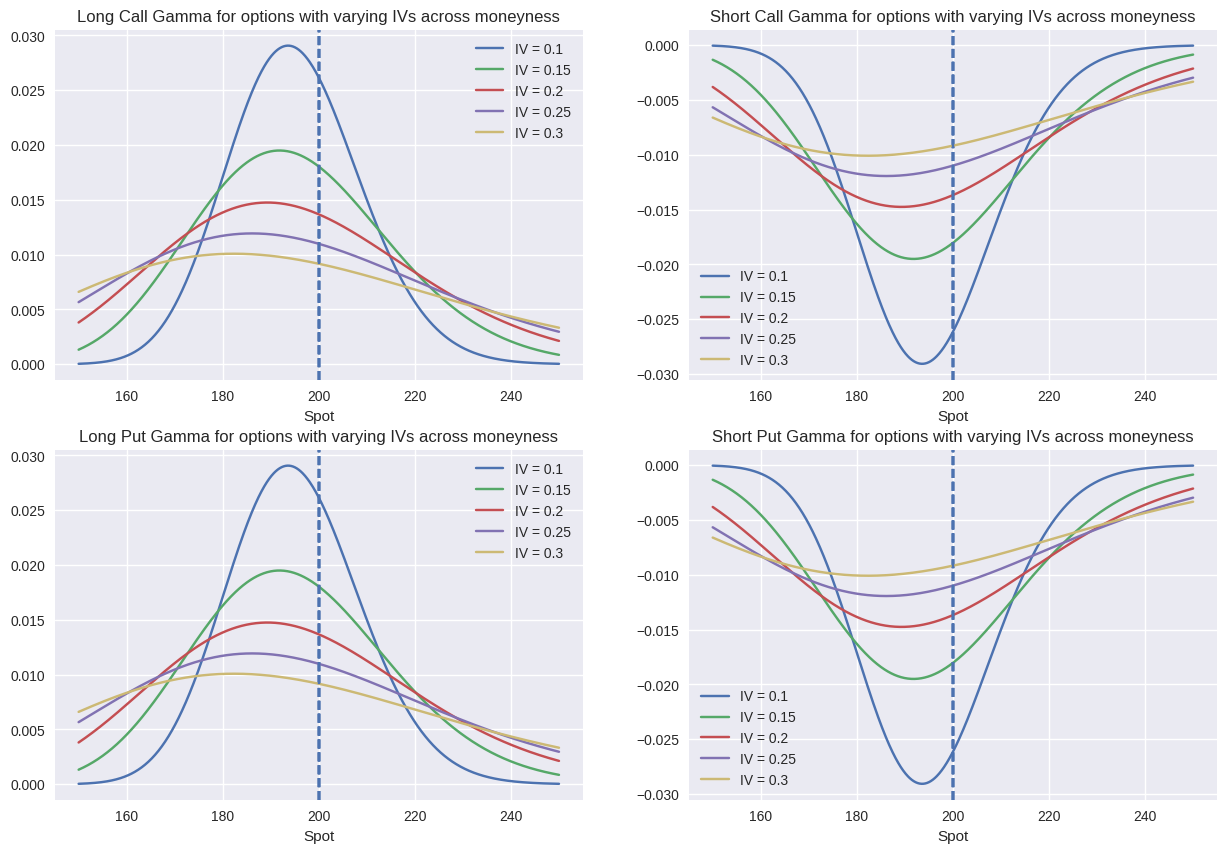

In [14]:
###############################
# Gamma
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate gamma across spots for each IV    
        gammas_per_iv = [
            [
                bsm.gamma(
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=iv,
                    t=t
                ) 
                for spot in spots
            ]
            for iv in ivs
        ]

        # Plot graph
        for gammas, iv in zip(gammas_per_iv, ivs):
            ax[i, j].plot(spots, gammas, label=f"IV = {iv}")
            ax[i, j].axvline(x=K, linestyle='--')
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Gamma for options with varying IVs across moneyness")
            ax[i, j].set_xlabel('Spot')

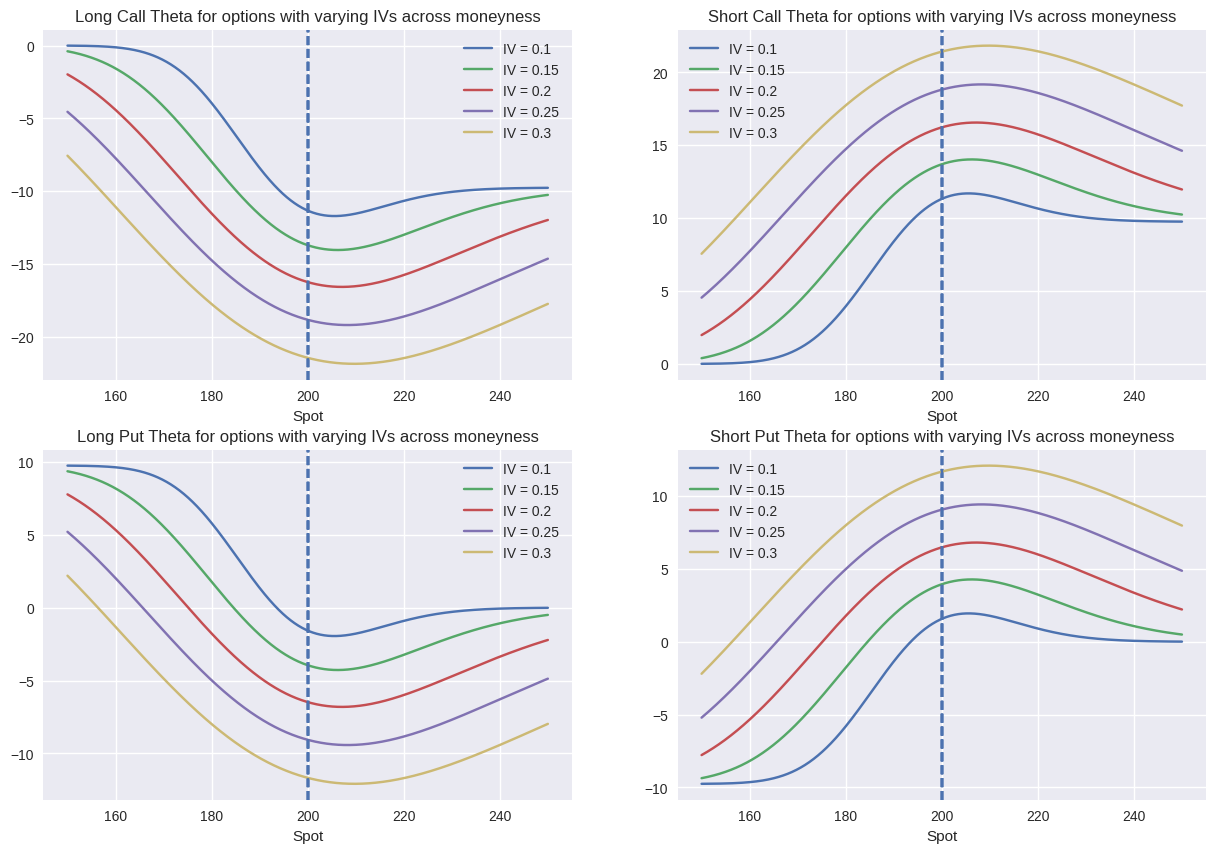

In [15]:
###############################
# Theta
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate theta across spots for each IV    
        thetas_per_iv = [
            [
                bsm.theta(
                    option_type=option_type,
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=iv,
                    t=t
                ) 
                for spot in spots
            ]
            for iv in ivs
        ]

        # Plot graph
        for thetas, iv in zip(thetas_per_iv, ivs):
            ax[i, j].plot(spots, thetas, label=f"IV = {iv}")
            ax[i, j].axvline(x=K, linestyle='--')
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Theta for options with varying IVs across moneyness")
            ax[i, j].set_xlabel('Spot')

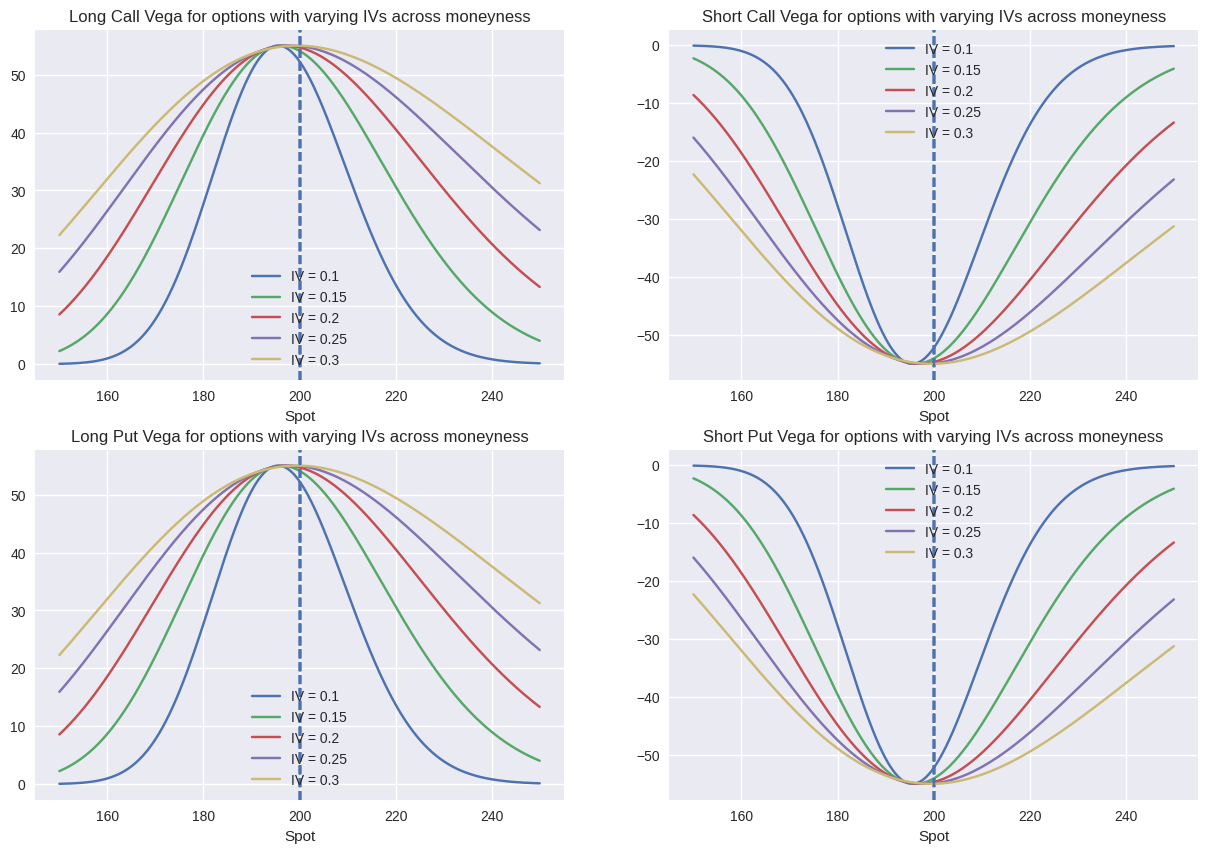

In [16]:
###############################
# Vega
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate vega across spots for each IV    
        vegas_per_iv = [
            [
                bsm.vega(
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=iv,
                    t=t
                ) 
                for spot in spots
            ]
            for iv in ivs
        ]

        # Plot graph
        for vegas, iv in zip(vegas_per_iv, ivs):
            ax[i, j].plot(spots, vegas, label=f"IV = {iv}")
            ax[i, j].axvline(x=K, linestyle='--')
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Vega for options with varying IVs across moneyness")
            ax[i, j].set_xlabel('Spot')

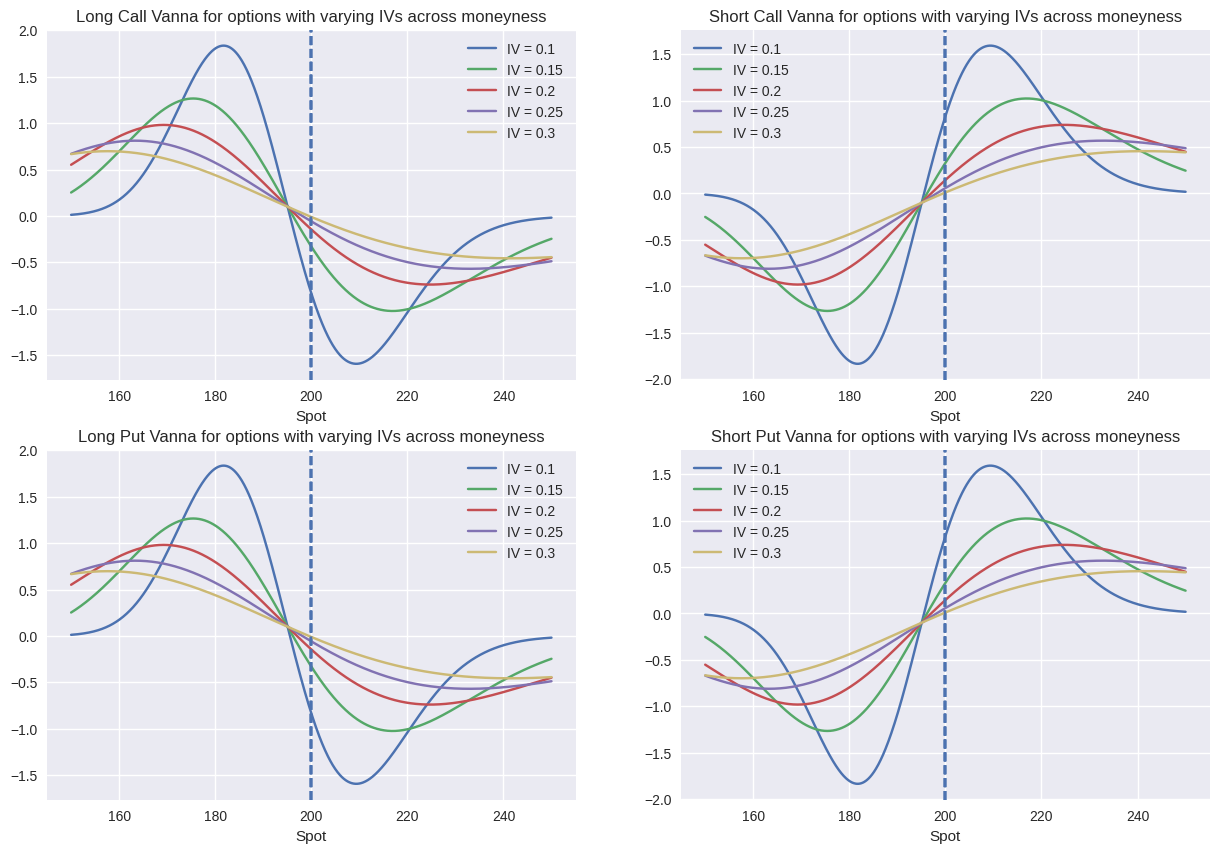

In [17]:
###############################
# Vanna
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate vanna across spots for each IV    
        vannas_per_iv = [
            [
                bsm.vanna(
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=iv,
                    t=t
                ) 
                for spot in spots
            ]
            for iv in ivs
        ]

        # Plot graph
        for vannas, iv in zip(vannas_per_iv, ivs):
            ax[i, j].plot(spots, vannas, label=f"IV = {iv}")
            ax[i, j].axvline(x=K, linestyle='--')
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Vanna for options with varying IVs across moneyness")
            ax[i, j].set_xlabel('Spot')

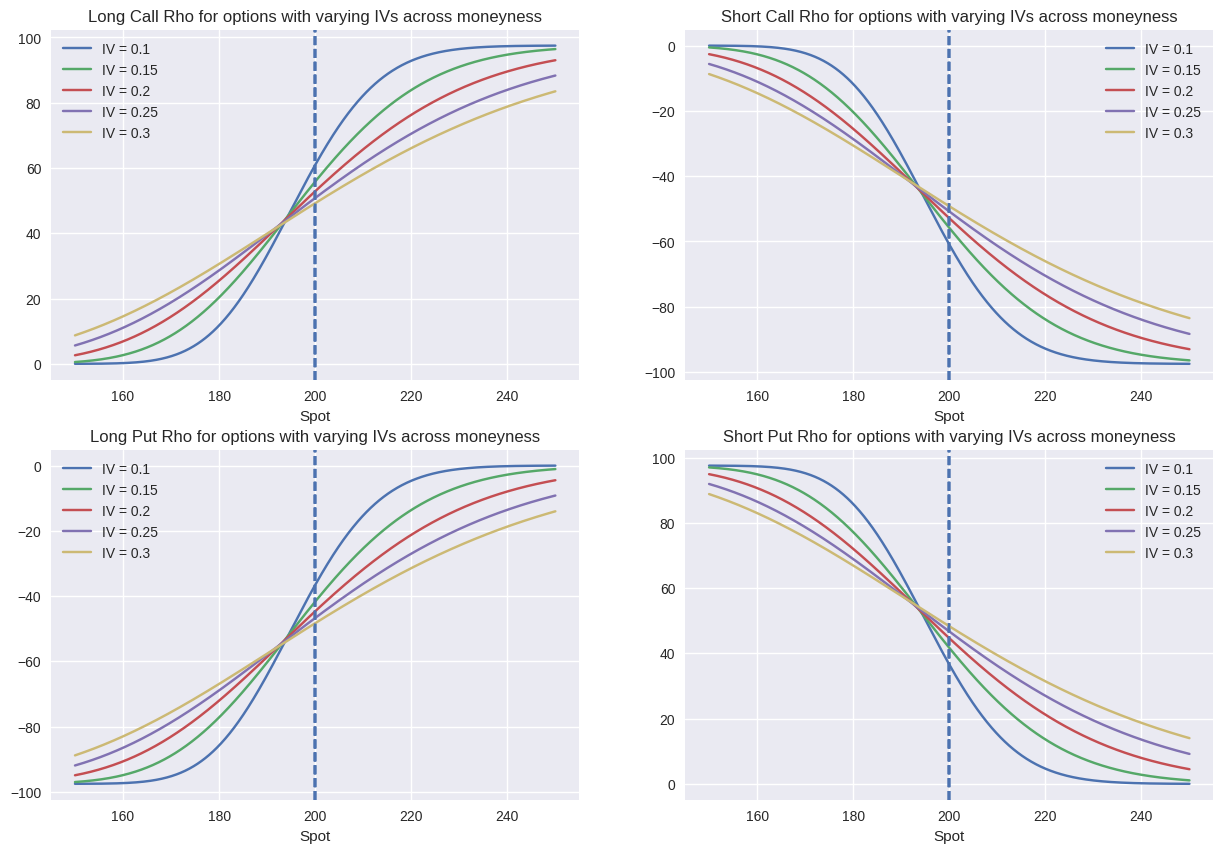

In [18]:
###############################
# Rho
###############################

# Set up subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, option_type in enumerate(option_types):
    for j, position in enumerate(positions):
        # Calculate rho across spots for each IV    
        rhos_per_iv = [
            [
                bsm.rho(
                    option_type=option_type,
                    position=position,
                    S=spot,
                    K=K,
                    r=r,
                    sigma=iv,
                    t=t
                ) 
                for spot in spots
            ]
            for iv in ivs
        ]

        # Plot graph
        for rhos, iv in zip(rhos_per_iv, ivs):
            ax[i, j].plot(spots, rhos, label=f"IV = {iv}")
            ax[i, j].axvline(x=K, linestyle='--')
            ax[i, j].legend()
            ax[i, j].set_title(f"{position} {option_type} Rho for options with varying IVs across moneyness")
            ax[i, j].set_xlabel('Spot')

# Payoff Diagrams

We take a look at various types of option position. These can be split into various useful categories (Natenberg)
* Basic Calls or Puts
* Delta-Neutral Volatility Spreads:
  * Symmetrical Strategies (no preference in underlying direction)
  * Non-Symmetrical Strtagies (preference in underlying direction)
* Bull/Bear Spreads (not Delta-Neutral)

In [19]:
# Range of spot prices for payoff diagrams
spots = np.linspace(170, 230, 1000)

## Basic Calls or Puts

#### Call

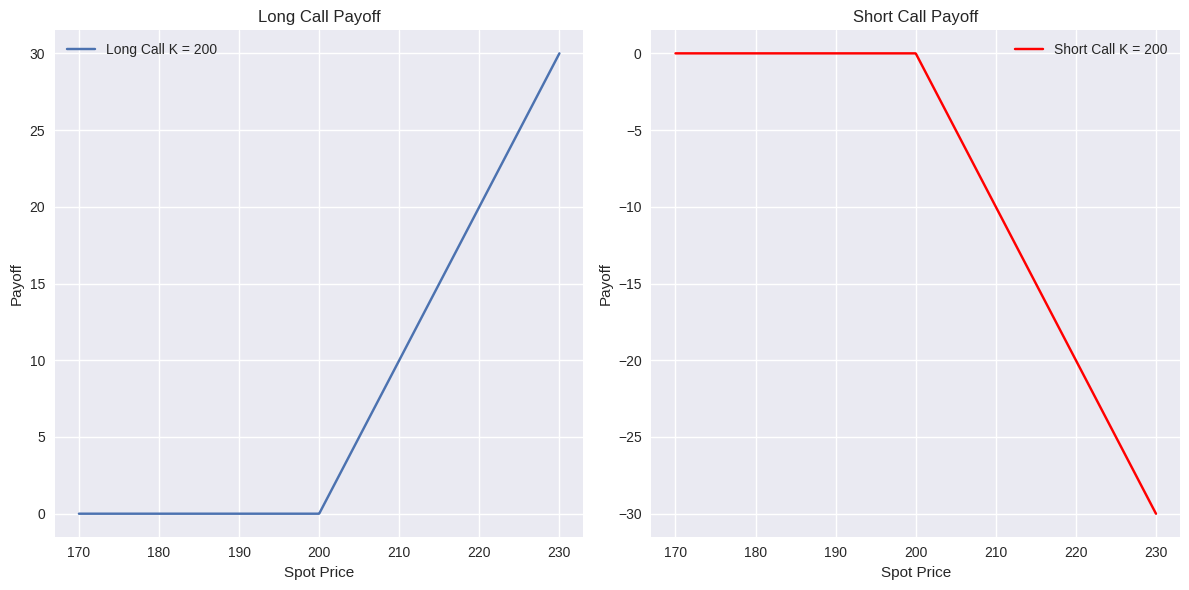

In [20]:
# Long call payoff
long_call_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Call'],
    positions=['Long'],
    strikes=[200]
)

# Short call payoff
short_call_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Call'],
    positions=['Short'],
    strikes=[200]
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(spots, long_call_payoff, label='Long Call K = 200')
axs[0].set_title('Long Call Payoff')
axs[0].set_xlabel('Spot Price')
axs[0].set_ylabel('Payoff')
axs[0].legend()
axs[0].grid(True)
axs[1].plot(spots, short_call_payoff, label='Short Call K = 200', color='red')
axs[1].set_title('Short Call Payoff')
axs[1].set_xlabel('Spot Price')
axs[1].set_ylabel('Payoff')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()

#### Put

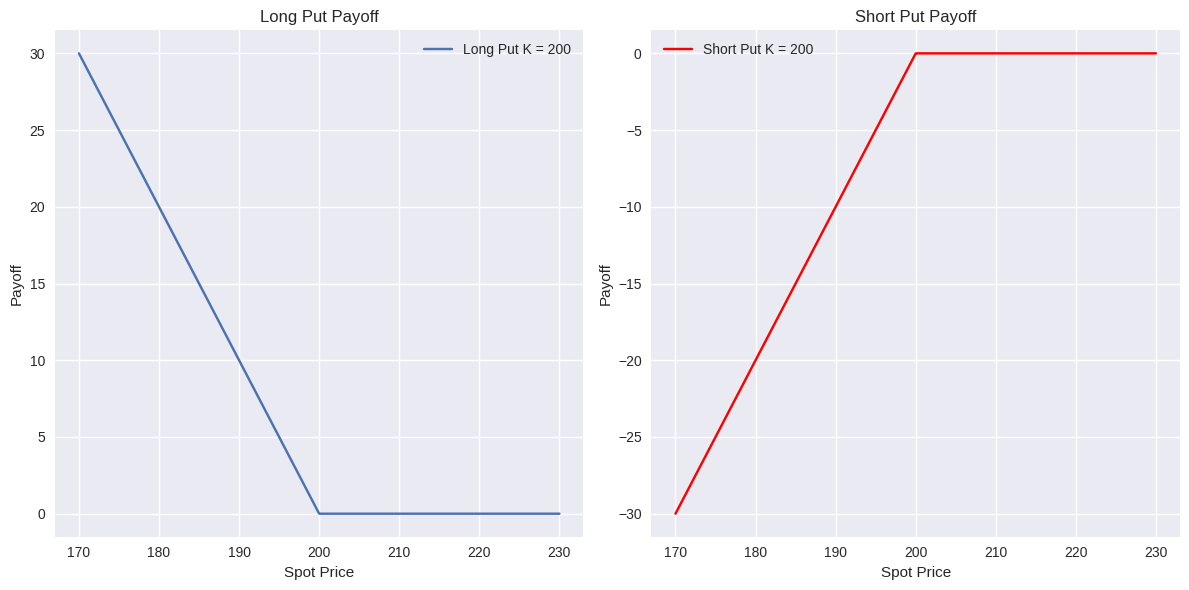

In [21]:
# Long put payoff
long_put_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Put'],
    positions=['Long'],
    strikes=[200]
)

# Short put payoff
short_put_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Put'],
    positions=['Short'],
    strikes=[200]
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(spots, long_put_payoff, label='Long Put K = 200')
axs[0].set_title('Long Put Payoff')
axs[0].set_xlabel('Spot Price')
axs[0].set_ylabel('Payoff')
axs[0].legend()
axs[0].grid(True)
axs[1].plot(spots, short_put_payoff, label='Short Put K = 200', color='red')
axs[1].set_title('Short Put Payoff')
axs[1].set_xlabel('Spot Price')
axs[1].set_ylabel('Payoff')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()

## Delta-Neutral Volatility Spreads

### Symmetrical Strategies

#### Straddle

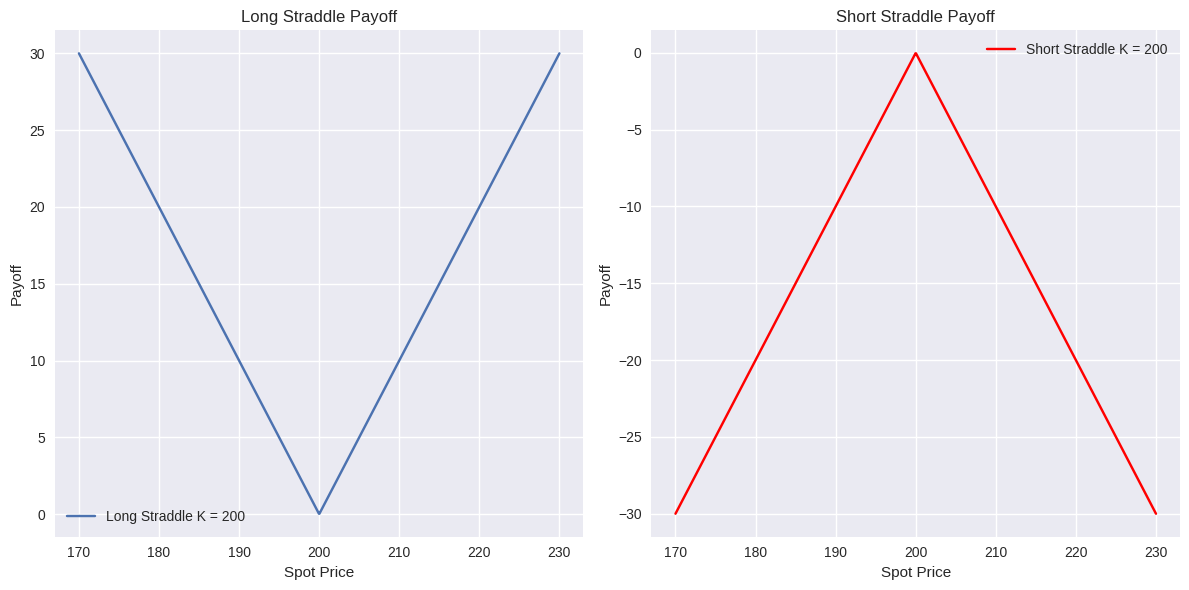

In [22]:
# Long straddle payoff
long_straddle_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Call', 'Put'],
    positions=['Long', 'Long'],
    strikes=[200, 200]
)

# Short straddle payoff
short_straddle_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Call', 'Put'],
    positions=['Short', 'Short'],
    strikes=[200, 200]
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(spots, long_straddle_payoff, label='Long Straddle K = 200')
axs[0].set_title('Long Straddle Payoff')
axs[0].set_xlabel('Spot Price')
axs[0].set_ylabel('Payoff')
axs[0].legend()
axs[0].grid(True)
axs[1].plot(spots, short_straddle_payoff, label='Short Straddle K = 200', color='red')
axs[1].set_title('Short Straddle Payoff')
axs[1].set_xlabel('Spot Price')
axs[1].set_ylabel('Payoff')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()

* A **long straddle** is a long call and a long put both with the same strike and expiry.
* A **short straddle** is a short call and a short put both with the same strike and expiry.
* Straddles typically use **ATM contracts** to achieve an approximately delta neutral position.
* Greeks:
 | Position        | Delta        | Gamma        | Theta        | Vega         |
|-----------------|--------------|--------------|--------------|--------------|
| Long Straddle   | Neutral      | Positive     | Negative     | Positive     |
| Short Straddle  | Neutral      | Negative     | Positive     | Negative     |

* P&L
| Position        | Max Profit        | Max Loss        | 
|-----------------|--------------|--------------|
| Long Straddle   | Unlimited      | Premium Paid     |
| Short Straddle  | Premium Collected      | Unlimited     |
  
* Long straddles benefit from movement in the underlying contract (long gamma) as well as any increase in implied volatility (long vega).
* Short straddles benefit from little movement in the underlying contract (short gamma) as well as any decrease in implied volatility (short vega)

#### Strangle

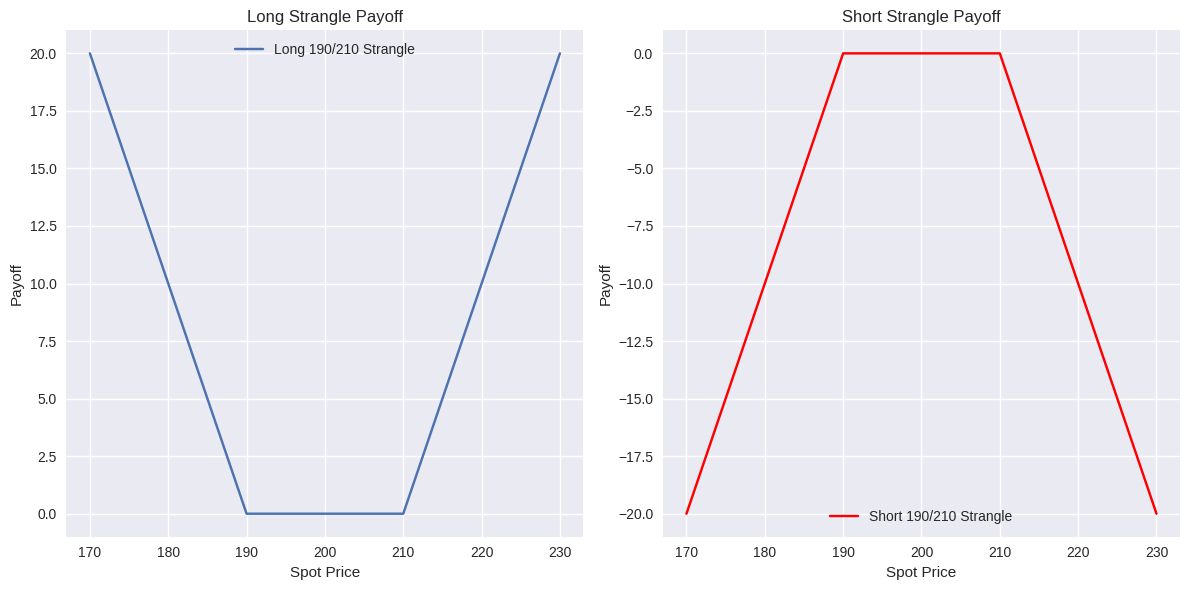

In [23]:
# Long strangle payoff
long_strangle_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Put', 'Call'],
    positions=['Long', 'Long'],
    strikes=[190, 210]
)

# Short strangle payoff
short_strangle_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Put', 'Call'],
    positions=['Short', 'Short'],
    strikes=[190, 210]
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(spots, long_strangle_payoff, label='Long 190/210 Strangle')
axs[0].set_title('Long Strangle Payoff')
axs[0].set_xlabel('Spot Price')
axs[0].set_ylabel('Payoff')
axs[0].legend()
axs[0].grid(True)
axs[1].plot(spots, short_strangle_payoff, label='Short 190/210 Strangle', color='red')
axs[1].set_title('Short Strangle Payoff')
axs[1].set_xlabel('Spot Price')
axs[1].set_ylabel('Payoff')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()

* A **long strangle** is a long call and a long put with different strikes but the same expiry.
* A **short strangle** is a short call and a short put with different strikes but the same expiry.
* Strikes are typically chosen to achieve an approximately delta neutral position.
* To avoid confusion of which strike corresponds to which option, strangles are assumed to use OTM options. So a 90/110 strangle with the underlying trading at 100 would consist of a 90 put and a 110 call.
* Greeks:
 | Position        | Delta        | Gamma        | Theta        | Vega         |
|-----------------|--------------|--------------|--------------|--------------|
| Long Strangle   | Neutral      | Positive     | Negative     | Positive     |
| Short Strangle  | Neutral      | Negative     | Positive     | Negative     |

* P&L
| Position        | Max Profit        | Max Loss        | 
|-----------------|--------------|--------------|
| Long Strangle   | Unlimited      | Premium Paid     |
| Short Strangle  | Premium Collected      | Unlimited     |
  
* Long strangles benefit from movement in the underlying contract (long gamma) as well as any increase in implied volatility (long vega).
* Short strangles benefit from little movement in the underlying contract (short gamma) as well as any decrease in implied volatility (short vega).

### Non-Symmetrical Strategies

#### Ratio Spreads

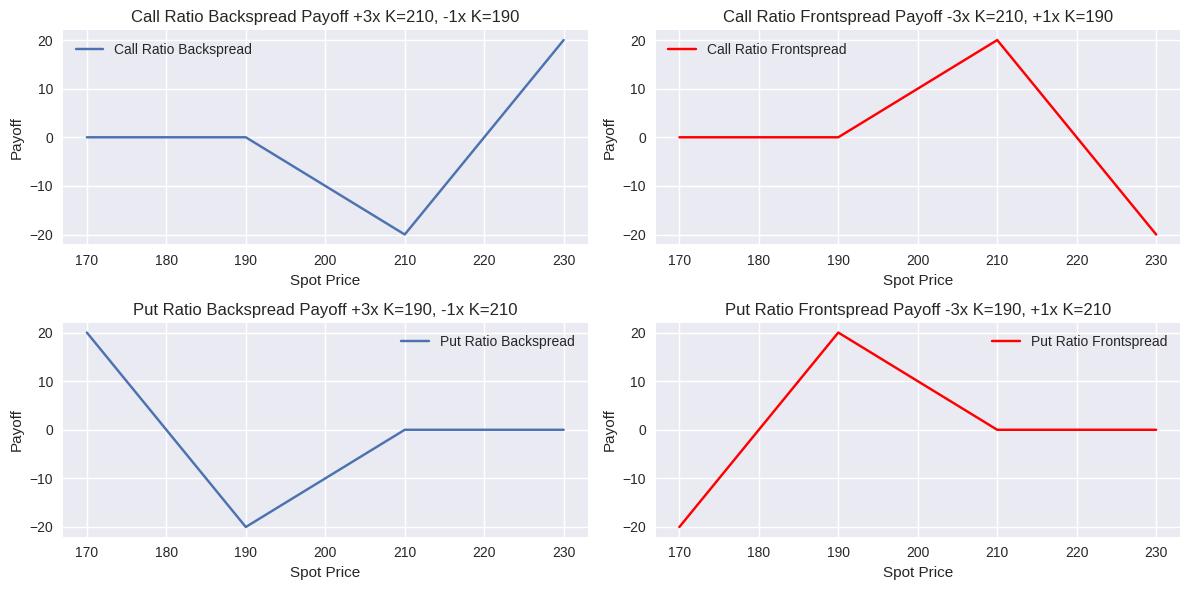

In [24]:
# Call ratio backspread payoff
call_ratio_backspread_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Call'] * 4,
    positions=['Long', 'Long', 'Long', 'Short'],
    strikes=[210, 210, 210, 190]
)

# Call ratio frontspread payoff
call_ratio_frontspread_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Call'] * 4,
    positions=['Short', 'Short', 'Short', 'Long'],
    strikes=[210, 210, 210, 190]
)

# Put ratio backspread payoff
put_ratio_backspread_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Put'] * 4,
    positions=['Long', 'Long', 'Long', 'Short'],
    strikes=[190, 190, 190, 210]
)

# Put ratio frontspread payoff
put_ratio_frontspread_payoff = bsm.position_payoff(
    spots=spots,
    option_types=['Put'] * 4,
    positions=['Short', 'Short', 'Short', 'Long'],
    strikes=[190, 190, 190, 210]
)


# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs[0, 0].plot(spots, call_ratio_backspread_payoff, label='Call Ratio Backspread')
axs[0, 0].set_title('Call Ratio Backspread Payoff +3x K=210, -1x K=190')
axs[0, 0].set_xlabel('Spot Price')
axs[0, 0].set_ylabel('Payoff')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 1].plot(spots, call_ratio_frontspread_payoff, label='Call Ratio Frontspread', color='red')
axs[0, 1].set_title('Call Ratio Frontspread Payoff -3x K=210, +1x K=190')
axs[0, 1].set_xlabel('Spot Price')
axs[0, 1].set_ylabel('Payoff')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[1, 0].plot(spots, put_ratio_backspread_payoff, label='Put Ratio Backspread')
axs[1, 0].set_title('Put Ratio Backspread Payoff +3x K=190, -1x K=210')
axs[1, 0].set_xlabel('Spot Price')
axs[1, 0].set_ylabel('Payoff')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 1].plot(spots, put_ratio_frontspread_payoff, label='Put Ratio Frontspread', color='red')
axs[1, 1].set_title('Put Ratio Frontspread Payoff -3x K=190, +1x K=210')
axs[1, 1].set_xlabel('Spot Price')
axs[1, 1].set_ylabel('Payoff')
axs[1, 1].legend()
axs[1, 1].grid(True)
plt.tight_layout()
plt.show()

* A *ratio spread* is a position that involves buying and selling different amounts of the same type of option where all options expire at the same time.
* Strikes are typically chosen so that the position is delta neutral.
* A ratio spread is useful when movement in one direction is deemed more likely than movement in the other direction.
* A *backspread* is when more options are bought than sold. A *frontspread* is when more options are sold than bought.
* TODO: Finish notes on these spreads.

#### Call Ratio Spreads


#### Calendar Spread

#### Diagonal Spread

## Bull/Bear Spreads (not Delta-Neutral)

TODO: Cover vertical spreads and bull/bear ratio spreads